In [1]:
# !pip install kaggle
# !kaggle competitions download -c dogs-vs-cats
# !sudo apt-get install unzip
# !unzip /notebooks/Cats_Dogs/train.zip
# !unzip /notebooks/Cats_Dogs/test1.zip

In [2]:
!pip install torchmetrics timm
import timm
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import imageio
import os
from PIL import Image
import time
import torch.nn.functional as F
from torchmetrics.classification import MulticlassF1Score

import torchmetrics
from torchmetrics.classification import F1Score, Accuracy, Recall, Precision
import random

In [3]:
def validate_(val_loader, loss_fn):
    predicted, actual = torch.tensor([]), torch.tensor([])
    with torch.no_grad():
        loss_test = 0.
        for img, label in tqdm(val_loader):
            img = img.to(device)
            label = label.to(device)
            img = img.type(torch.float32)
            out = net(img)
            
            out = torch.nn.functional.softmax(out, dim=1)
            loss_test += loss_fn(out,label)
            
            predicted = torch.cat((predicted, out.cpu()))
            actual = torch.cat((actual, label.cpu()))
            
    print('Validation loss', loss_test.item()/len(val_loader))
    return loss_test.item()/len(val_loader), predicted, actual

def test_(test_loader):
    with torch.no_grad():
        output, file_names_batch = torch.tensor([]), []
        for img, file_name in tqdm(test_loader):
            img = img.to(device)
            img = img.type(torch.float32)
            out = net(img)
            
            out = torch.nn.functional.softmax(out, dim=1)
            
            output = torch.cat((output, out.cpu()))
            file_names_batch.append(file_name)
        files=[]
        _ = [files.append(f) for i in file_names_batch for f in i]
        
        out = {i:j for (i,j) in zip(files,output)}
        
        return out

def calculate_metrics(output, label):
    f1score = F1Score(num_classes = 2, task='multiclass')
    acc = Accuracy(num_classes = 2, task='multiclass')
    recall = Recall(num_classes = 2, task='multiclass')
    precision = Precision(num_classes = 2, task='multiclass')
    
#     print('F1 Score - ', f1score(output, label), ' Accuracy - ', acc(output, label))
    return f1score(output, label), acc(output, label)

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
crop_size = 256
torch.manual_seed(1)

In [6]:
import os

train_files = os.listdir('./train/')
test_files = os.listdir('./test1/')

In [7]:
transform = transforms.Compose([
    transforms.Resize(crop_size),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
])

In [8]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, train_mode=True):
        self.file_list = file_list
        self.train_mode = train_mode
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        if self.train_mode:
            img = Image.open(os.path.join('/notebooks/Cats_Dogs/train', self.file_list[idx]))
            img = transform(img)
            
            label = 1 if self.file_list[idx].split('.')[0] == 'dog' else 0
            
            return img, label
        else:
            img = Image.open(os.path.join('/notebooks/Cats_Dogs/test1', self.file_list[idx]))
            img = transform(img)
            
            return img, self.file_list[idx]

In [9]:
all_dogs = [i for i in train_files if i.split('.')[0]=='dog']
all_cats = [i for i in train_files if i.split('.')[0]=='cat']

def split_dataset(list_of_files, split_ratio = 0.8):
    train_len = int(len(list_of_files)*0.8)
    
    return list_of_files[:train_len], list_of_files[train_len:]

train_list_dogs, val_list_dogs = split_dataset(all_dogs, 0.8)
train_list_cats, val_list_cats = split_dataset(all_cats, 0.8)

train_list_dogs.extend(train_list_cats)
val_list_dogs.extend(val_list_cats)

train_list = train_list_dogs
val_list = val_list_dogs

In [10]:
train_ds = CatDogDataset(train_list, train_mode=True)
val_ds = CatDogDataset(val_list, train_mode=True)
test_ds = CatDogDataset(test_files, train_mode=False)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [11]:
# timm.list_models('res*')

In [12]:
net = timm.create_model('efficientnet_b0', pretrained=True, in_chans=3, num_classes=2, drop_rate=0.2)

In [13]:
params = [i.numel() for i in net.parameters() if i.requires_grad is True]
print(f"Number of learnable parameters in the model - {sum(params):.2E}")

Number of learnable parameters in the model - 4.01E+06


In [14]:
net.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [15]:
epochs = 10
   
for i in range(epochs):
    loss_train=0
    predicted, actual = torch.tensor([]), torch.tensor([])
    for sample, labels in tqdm(train_loader):
        
        sample = sample.to(device)
        labels = labels.to(device)
        
        output = net(sample)
        output = torch.nn.functional.softmax(output, dim=1)
                
        loss = loss_fn(output, labels)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loss_train += loss.item()
                
        predicted = torch.cat((predicted, output.cpu()))
        actual = torch.cat((actual, labels.cpu()))
    
    f1, acc = calculate_metrics(predicted.cpu(), actual.cpu())
    print(f"Epoch - {i+1:2}")
    print(f"Train loss - {loss_train/len(train_loader):15}, Train F1 - {f1*100:15}, Train Acc - {acc*100:15}")
    
    val_loss, val_pred, val_actual = validate_(val_loader, loss_fn)
    f1, acc = calculate_metrics(val_pred.cpu(), val_actual.cpu())
    print(f"Val loss - {val_loss:15}, Val F1 - {f1*100:15}, Val Acc - {acc*100:15}")
    
    if val_loss > 1.1*loss_train/len(train_loader):
        print("Overfitting. So exiting")
        break
torch.save(net.state_dict(), './model.pt')

100%|██████████| 625/625 [03:33<00:00,  2.93it/s]


Epoch -  1
Train loss - 0.5334290534973144, Train F1 - 76.6449966430664, Train Acc - 76.6449966430664


100%|██████████| 157/157 [00:35<00:00,  4.48it/s]


Validation loss 0.4223508409633758
Val loss - 0.4223508409633758, Val F1 - 88.73999786376953, Val Acc - 88.73999786376953


100%|██████████| 625/625 [03:33<00:00,  2.92it/s]


Epoch -  2
Train loss - 0.4011254195690155, Train F1 - 90.7750015258789, Train Acc - 90.7750015258789


100%|██████████| 157/157 [00:37<00:00,  4.22it/s]


Validation loss 0.38912805933861216
Val loss - 0.38912805933861216, Val F1 - 91.87999725341797, Val Acc - 91.87999725341797


100%|██████████| 625/625 [03:22<00:00,  3.09it/s]


Epoch -  3
Train loss - 0.37739845442771913, Train F1 -           93.25, Train Acc -           93.25


100%|██████████| 157/157 [00:30<00:00,  5.09it/s]


Validation loss 0.3726872972622039
Val loss - 0.3726872972622039, Val F1 - 93.63999938964844, Val Acc - 93.63999938964844


100%|██████████| 625/625 [02:57<00:00,  3.52it/s]


Epoch -  4
Train loss - 0.3677805519104004, Train F1 - 94.23999786376953, Train Acc - 94.23999786376953


100%|██████████| 157/157 [00:31<00:00,  5.02it/s]


Validation loss 0.36250295456807324
Val loss - 0.36250295456807324, Val F1 - 94.8800048828125, Val Acc - 94.8800048828125


100%|██████████| 625/625 [02:51<00:00,  3.65it/s]


Epoch -  5
Train loss - 0.3618399356365204, Train F1 - 94.82499694824219, Train Acc - 94.82499694824219


100%|██████████| 157/157 [00:24<00:00,  6.29it/s]


Validation loss 0.3571649053294188
Val loss - 0.3571649053294188, Val F1 -            95.5, Val Acc -            95.5


100%|██████████| 625/625 [02:54<00:00,  3.59it/s]


Epoch -  6
Train loss - 0.35720292468070985, Train F1 - 95.36499786376953, Train Acc - 95.36499786376953


100%|██████████| 157/157 [00:26<00:00,  5.86it/s]


Validation loss 0.3576550817793342
Val loss - 0.3576550817793342, Val F1 - 95.4800033569336, Val Acc - 95.4800033569336


100%|██████████| 625/625 [02:51<00:00,  3.64it/s]


Epoch -  7
Train loss - 0.3532984169960022, Train F1 - 95.80000305175781, Train Acc - 95.80000305175781


100%|██████████| 157/157 [00:33<00:00,  4.72it/s]


Validation loss 0.35143564309284187
Val loss - 0.35143564309284187, Val F1 - 95.94000244140625, Val Acc - 95.94000244140625


100%|██████████| 625/625 [03:06<00:00,  3.35it/s]


Epoch -  8
Train loss - 0.34862998785972593, Train F1 - 96.29000091552734, Train Acc - 96.29000091552734


100%|██████████| 157/157 [00:26<00:00,  5.97it/s]


Validation loss 0.3504578171262316
Val loss - 0.3504578171262316, Val F1 - 96.04000091552734, Val Acc - 96.04000091552734


100%|██████████| 625/625 [03:01<00:00,  3.45it/s]


Epoch -  9
Train loss - 0.3491217393398285, Train F1 - 96.27999877929688, Train Acc - 96.27999877929688


100%|██████████| 157/157 [00:33<00:00,  4.69it/s]


Validation loss 0.35330754176826235
Val loss - 0.35330754176826235, Val F1 - 95.77999877929688, Val Acc - 95.77999877929688


100%|██████████| 625/625 [03:01<00:00,  3.44it/s]


Epoch - 10
Train loss - 0.3454144602775574, Train F1 - 96.66500091552734, Train Acc - 96.66500091552734


100%|██████████| 157/157 [00:27<00:00,  5.80it/s]

Validation loss 0.3498074719860296
Val loss - 0.3498074719860296, Val F1 - 96.12000274658203, Val Acc - 96.12000274658203


In [16]:
torch.save(net.state_dict(), './model.pt')

In [17]:
output = test_(test_loader)

100%|██████████| 391/391 [01:50<00:00,  3.53it/s]


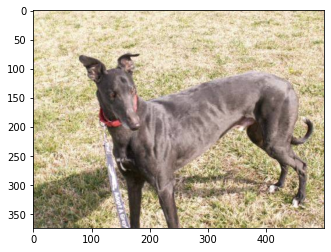

Cat 0.0, Dog 100.0


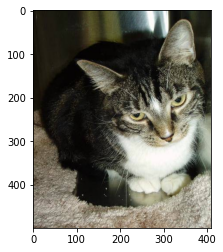

Cat 100.0, Dog 0.0


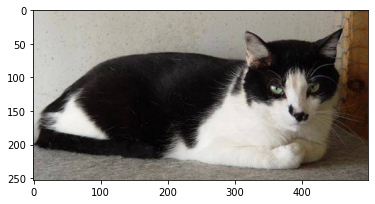

Cat 100.0, Dog 0.0


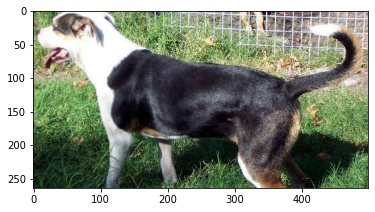

Cat 0.0, Dog 100.0


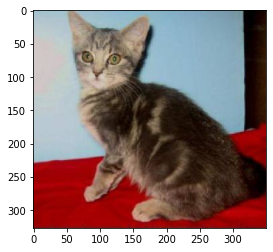

Cat 100.0, Dog 0.0


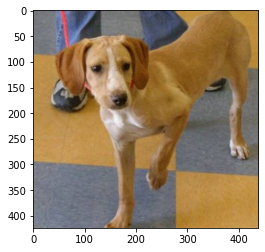

Cat 0.0, Dog 100.0


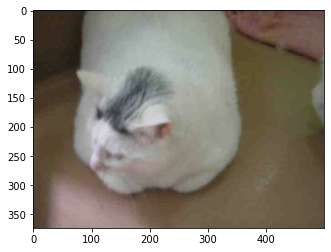

Cat 100.0, Dog 0.0


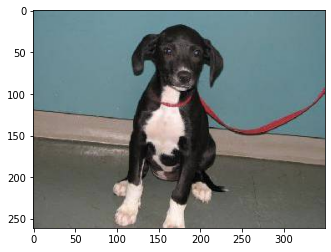

Cat 0.0, Dog 100.0


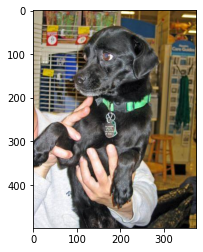

Cat 0.0, Dog 100.0


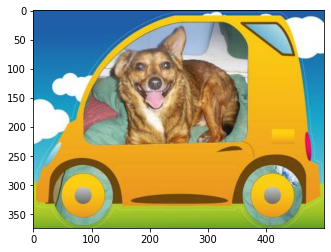

Cat 0.0, Dog 100.0


In [22]:
for i in random.sample(list(output.keys()), 10):
    img = Image.open('./test1/' + i)
    plt.imshow(img)
    plt.show()
    print(f"Cat {torch.round(output[i][0]*100)}, Dog {torch.round(output[i][1]*100)}")
    #print(output[i])

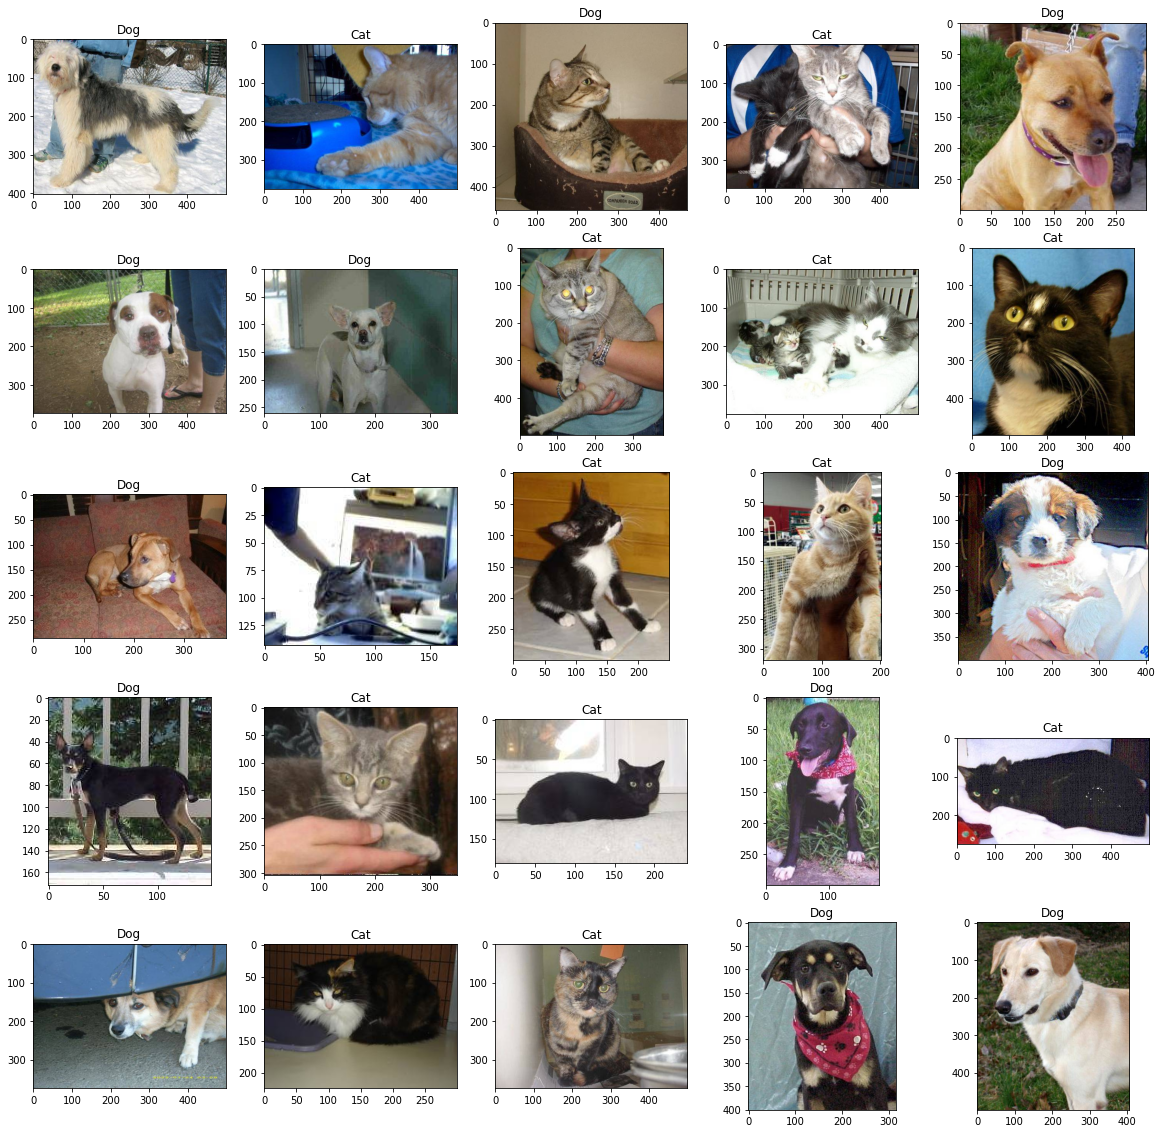

In [32]:
fig = plt.figure(figsize=(20, 20))
for i, img in enumerate(random.sample(list(output.keys()), 25)):
    ax = fig.add_subplot(5, 5, i+1)
    image = Image.open('./test1/' + img)
    plt.imshow(image)
    label = "Cat" if output[img][0] > output[img][1] else "Dog"
    ax.title.set_text(label)

In [19]:
output_mixed = {}
for k in output:
    if abs(output[k][0] - output[k][1]) < 0.2:
        output_mixed[k] = output[k]

In [20]:
len(output_mixed)

71

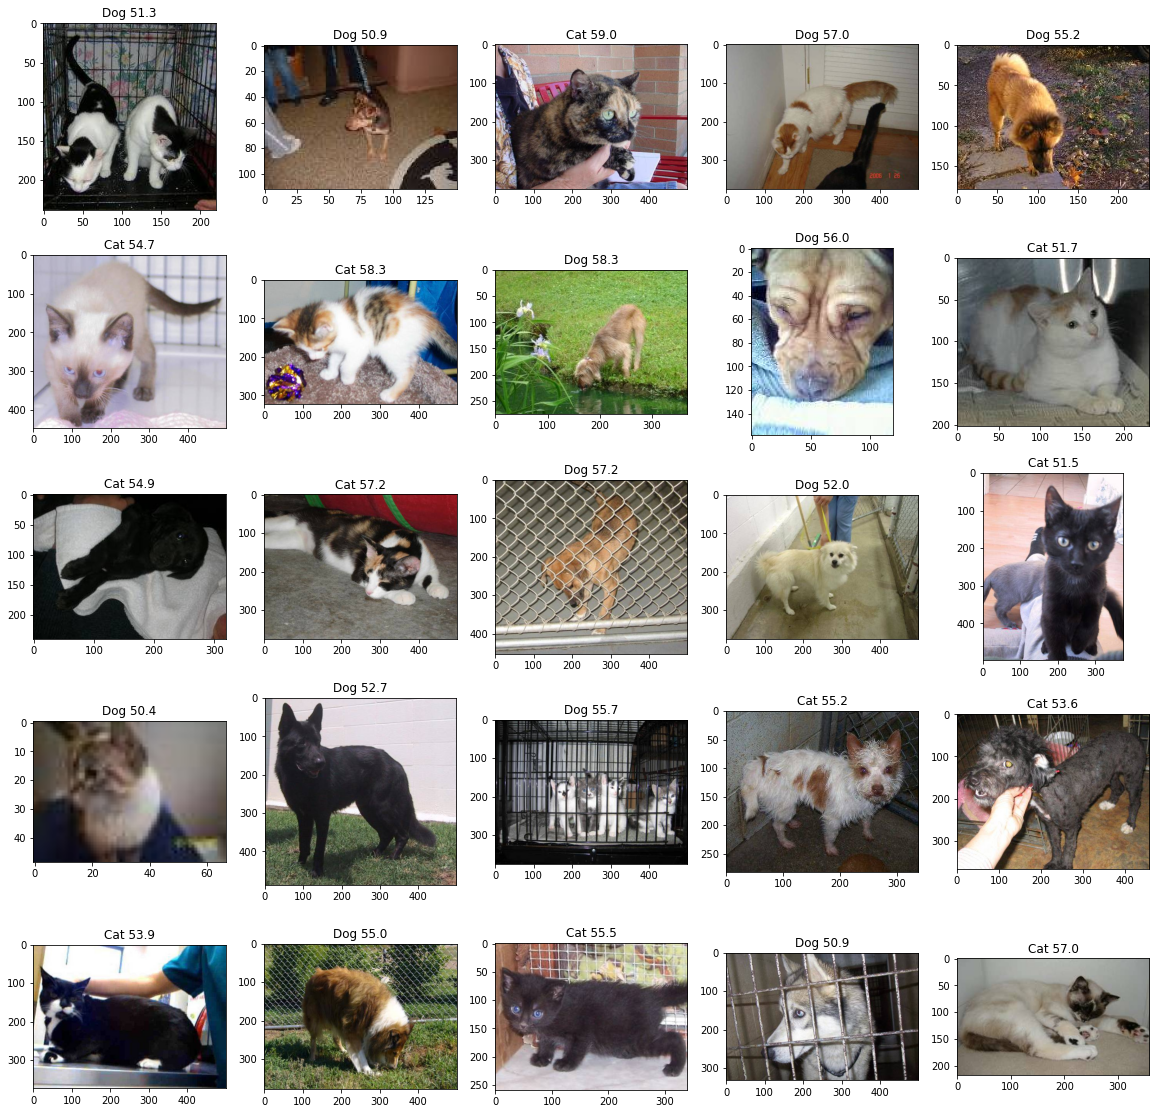

In [41]:
fig = plt.figure(figsize=(20, 20))
for i, img in enumerate(random.sample(list(output_mixed.keys()), 25)):
    ax = fig.add_subplot(5, 5, i+1)
    image = Image.open('./test1/' + img)
    plt.imshow(image)
    label = "Cat "+str(np.round(output[img][0].numpy()*100,1)) if output[img][0] > output[img][1] else "Dog "+str(np.round(output[img][1].numpy()*100,1))
    ax.title.set_text(label)